In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa

## Load labeled/unlabeled train dataset, validation dataset and test dataset

In [2]:
TRAIN_DIR = '../../../data/cell_type/training'
TEST_DIR = '../../../data/cell_type/testing'
VAL_DIR = '../../../data/cell_type/validation'
UNLABELLED_DIR = '../../../data/cell_type/unlabelled'

BATCH_SIZE = 256
IMG_SIZE = (32, 32)


labelled_train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='nearest',
#                                              label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
#                                                   label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
#                                                   label_mode='categorical'
                                            )

unlabelled_train_dataset = image_dataset_from_directory(UNLABELLED_DIR,
                                                  shuffle=True,
                                                  batch_size=128,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
                                                  label_mode=None
                                            )


Found 7915 files belonging to 4 classes.
Found 990 files belonging to 4 classes.
Found 991 files belonging to 4 classes.
Found 10384 files belonging to 1 classes.


## Hyperparameters

In [22]:
# Dataset hyperparameters
unlabeled_dataset_size = 10384
labeled_dataset_size = 7915
image_size = 32
image_channels = 3

# Algorithm hyperparameters
num_epochs = 100
batch_size = 525
width = 128
temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [4]:
steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
labeled_batch_size = labeled_dataset_size // steps_per_epoch

In [5]:
steps_per_epoch

34

In [6]:
unlabeled_batch_size

305

In [7]:
labeled_batch_size

232

In [8]:
# Labeled and unlabeled datasets are zipped together
train_dataset = tf.data.Dataset.zip(
    (unlabelled_train_dataset, labelled_train_dataset)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image augmentation

In [9]:
# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - tf.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            preprocessing.Rescaling(1 / 255), #rescale 
            preprocessing.RandomFlip("horizontal"), #horizontal flip
            preprocessing.RandomRotation(0.2) #rotation
        ]
    )

In [10]:
# # Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )


In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
# Baseline supervised training with random initialization
baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(4),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    labelled_train_dataset, epochs=num_epochs, validation_data=validation_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/100
31/31 [==============================] - 3s 11ms/step - loss: 1.2194 - acc: 0.4567 - val_loss: 0.9750 - val_acc: 0.6131
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 0.9438 - acc: 0.6347 - val_loss: 0.8364 - val_acc: 0.6879
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.8140 - acc: 0.6881 - val_loss: 0.7761 - val_acc: 0.6990
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.8260 - acc: 0.6777 - val_loss: 0.7776 - val_acc: 0.6838
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7856 - acc: 0.6983 - val_loss: 0.7454 - val_acc: 0.6970
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.8021 - acc: 0.6853 - val_loss: 0.7681 - val_acc: 0.6939
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7648 - acc: 0.7045 - val_loss: 0.7282 - val_acc: 0.7101
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7461 - 

31/31 [==============================] - 0s 5ms/step - loss: 0.5296 - acc: 0.7999 - val_loss: 0.5553 - val_acc: 0.7919
Epoch 60/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5438 - acc: 0.7877 - val_loss: 0.5499 - val_acc: 0.7848
Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5401 - acc: 0.7933 - val_loss: 0.5591 - val_acc: 0.7838
Epoch 62/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5354 - acc: 0.7949 - val_loss: 0.5582 - val_acc: 0.7798
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5220 - acc: 0.7984 - val_loss: 0.5332 - val_acc: 0.7980
Epoch 64/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5207 - acc: 0.7979 - val_loss: 0.5824 - val_acc: 0.7788
Epoch 65/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5260 - acc: 0.7980 - val_loss: 0.5679 - val_acc: 0.7808
Epoch 66/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5348 - acc: 0

# Self-supervised model for contrastive pretraining

In [15]:

# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(4)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        unlabeled_images, (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images)
        augmented_images_2 = self.contrastive_augmenter(images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1)
            features_2 = self.encoder(augmented_images_2)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1)
            projections_2 = self.projection_head(features_2)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features = self.encoder(preprocessed_images)
            class_logits = self.linear_probe(features)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=validation_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 15, 15, 128)       3584      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 128)         147584    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 128)         147584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
Total params: 462,848
Trainable params: 462,848
Non-trainable params: 0
_____________________________________________________

31/31 [==============================] - 0s 10ms/step - c_loss: 0.0752 - c_acc: 1.0000 - p_loss: 0.7701 - p_acc: 0.7031 - val_p_loss: 0.7537 - val_p_acc: 0.7030
Epoch 31/100
31/31 [==============================] - 0s 9ms/step - c_loss: 0.0776 - c_acc: 1.0000 - p_loss: 0.7685 - p_acc: 0.7017 - val_p_loss: 0.7501 - val_p_acc: 0.6960
Epoch 32/100
31/31 [==============================] - 0s 10ms/step - c_loss: 0.0771 - c_acc: 1.0000 - p_loss: 0.7656 - p_acc: 0.6999 - val_p_loss: 0.7631 - val_p_acc: 0.6859
Epoch 33/100
31/31 [==============================] - 0s 9ms/step - c_loss: 0.0795 - c_acc: 1.0000 - p_loss: 0.7681 - p_acc: 0.7054 - val_p_loss: 0.7491 - val_p_acc: 0.7051
Epoch 34/100
31/31 [==============================] - 0s 9ms/step - c_loss: 0.0731 - c_acc: 1.0000 - p_loss: 0.7645 - p_acc: 0.7022 - val_p_loss: 0.7584 - val_p_acc: 0.7051
Epoch 35/100
31/31 [==============================] - 0s 9ms/step - c_loss: 0.0730 - c_acc: 1.0000 - p_loss: 0.7601 - p_acc: 0.7011 - val_p_loss: 

31/31 [==============================] - 0s 9ms/step - c_loss: 0.0522 - c_acc: 1.0000 - p_loss: 0.7166 - p_acc: 0.7208 - val_p_loss: 0.6807 - val_p_acc: 0.7253
Epoch 78/100
31/31 [==============================] - 0s 10ms/step - c_loss: 0.0511 - c_acc: 1.0000 - p_loss: 0.7145 - p_acc: 0.7236 - val_p_loss: 0.7177 - val_p_acc: 0.7182
Epoch 79/100
31/31 [==============================] - 0s 10ms/step - c_loss: 0.0529 - c_acc: 1.0000 - p_loss: 0.7207 - p_acc: 0.7172 - val_p_loss: 0.7178 - val_p_acc: 0.7010
Epoch 80/100
31/31 [==============================] - 0s 9ms/step - c_loss: 0.0547 - c_acc: 1.0000 - p_loss: 0.7130 - p_acc: 0.7210 - val_p_loss: 0.6908 - val_p_acc: 0.7202
Epoch 81/100
31/31 [==============================] - 0s 9ms/step - c_loss: 0.0520 - c_acc: 1.0000 - p_loss: 0.7090 - p_acc: 0.7243 - val_p_loss: 0.7025 - val_p_acc: 0.7131
Epoch 82/100
31/31 [==============================] - 0s 9ms/step - c_loss: 0.0527 - c_acc: 1.0000 - p_loss: 0.7185 - p_acc: 0.7157 - val_p_loss: 

In [16]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(4),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labelled_train_dataset, epochs=num_epochs, validation_data=validation_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/100
31/31 [==============================] - 1s 8ms/step - loss: 1.0427 - acc: 0.5589 - val_loss: 0.8991 - val_acc: 0.6404
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.8241 - acc: 0.6825 - val_loss: 0.7735 - val_acc: 0.6929
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7785 - acc: 0.6988 - val_loss: 0.7544 - val_acc: 0.6970
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7671 - acc: 0.7026 - val_loss: 0.7612 - val_acc: 0.7020
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7583 - acc: 0.7073 - val_loss: 0.7192 - val_acc: 0.7101
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7494 - acc: 0.7066 - val_loss: 0.7325 - val_acc: 0.7071
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7363 - acc: 0.7102 - val_loss: 0.7161 - val_acc: 0.7131
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 0.7272 - a

Epoch 61/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5399 - acc: 0.7889 - val_loss: 0.5688 - val_acc: 0.7828
Epoch 62/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5532 - acc: 0.7817 - val_loss: 0.5912 - val_acc: 0.7687
Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5400 - acc: 0.7919 - val_loss: 0.5761 - val_acc: 0.7828
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5547 - acc: 0.7858 - val_loss: 0.5649 - val_acc: 0.7727
Epoch 65/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5286 - acc: 0.7933 - val_loss: 0.5921 - val_acc: 0.7596
Epoch 66/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5505 - acc: 0.7875 - val_loss: 0.5905 - val_acc: 0.7606
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 0.5327 - acc: 0.7947 - val_loss: 0.5661 - val_acc: 0.7949
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 0.

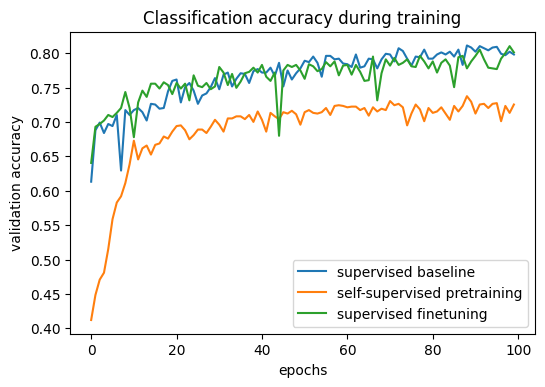

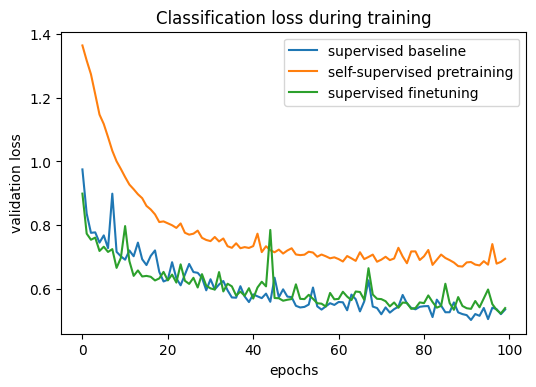

In [17]:

# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(6, 4), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

In [18]:
# loss, test_acc, test_f1_score, test_precision_m, test_recall_m = baseline_model.evaluate(test_dataset)

In [19]:
# loss, test_acc, test_f1_score, test_precision_m, test_recall_m = finetuning_model.evaluate(test_dataset)

In [20]:
loss, test_acc = baseline_model.evaluate(test_dataset)

4/4 [==============================] - 0s 13ms/step - loss: 0.5781 - acc: 0.7760


In [21]:
loss, test_acc = finetuning_model.evaluate(test_dataset)

4/4 [==============================] - 0s 2ms/step - loss: 0.5560 - acc: 0.7962
